In [2]:
import numpy as np
import caffe
from caffe.proto import caffe_pb2
import lmdb
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
%matplotlib notebook

In [2]:
import sys
sys.path.append('libs/')
from lmdb_utils import *
from numpy.random import seed
from numpy.random import shuffle

In [3]:
#Fijar modo de caffe CPU
#caffe.set_mode_cpu()

#Fijar modo de caffe GPU
caffe.set_device(0)
caffe.set_mode_gpu()

# 1.- Preparar base de datos

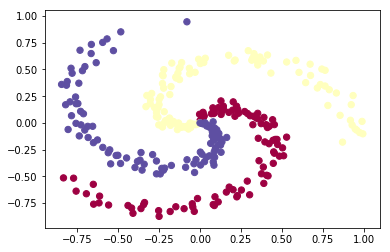

In [3]:
#Generar datos de entenamiento
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes

#Init data arrays
X = np.zeros((N*K,D)) #Data
y = np.zeros(N*K, dtype='uint8') #Labels

#Set data
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
    
#Plot data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

(300,)
(300, 2)


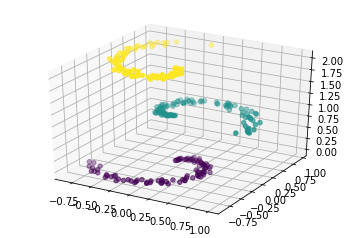

In [4]:
#Crear vector de indices aleatorios
seed(1)
rnd = [i for i in range(X.shape[0])]
shuffle(rnd)
print(y.shape)
print(X.shape)

#Desordenar entrada
a_d = np.zeros([X.shape[0], 3])
for i in range(len(rnd)):
    a_d[i,0:2] = X[rnd[i],:]
    a_d[i,2] = int(y[rnd[i]])
    
#Imprimir datos
a = a_d
ax= plt.axes (projection = '3d')
ax.scatter(a_d[:,0],a_d[:,1],a_d[:,2], marker='o', c=a_d[:,2])

In [5]:
#Inicializar arreglos en forma de blobs
data_train = np.zeros([int(0.9*N*3), 1, 1, D])
label_train = np.zeros([int(0.9*N*3),1,])
data_val = np.zeros([int(0.1*N*3), 1, 1, D])
label_val = np.zeros([int(0.1*N*3),1,])

#Distribucion de arreglos
train_s = int(0.9*a_d.shape[0])
val_s = int(0.1*a_d.shape[0])

#Redimensionar entradas en forma de blobs (Entrenamiento)
for i in range(train_s):
    data_train[i,0,0,:] = a_d[i, 0:2]
    label_train[i,0] = a_d[i,2]
               
#Redimensionar entradas en forma de blobs (Validacion)
for i in range(val_s):
    data_val[i,0,0,:] = a_d[i + val_s, 0:2]
    label_val[i,0] = a_d[i + val_s,2]

print('----- Datos de entrenamiento -----')
print('Tamaño de la entrada: ' +  str(data_train.shape))
print('Tamaño de etiquetas: ' + str(label_train.shape))

print('----- Datos de validacion -----')
print('Tamaño de la entrada: ' +  str(data_val.shape))
print('Tamaño de etiquetas: ' + str(label_val.shape))

----- Datos de entrenamiento -----
Tamaño de la entrada: (270, 1, 1, 2)
Tamaño de etiquetas: (270, 1)
----- Datos de validacion -----
Tamaño de la entrada: (30, 1, 1, 2)
Tamaño de etiquetas: (30, 1)


In [6]:
#Path de guardado de bases de datos
path = "dataset/"

#Crear bases de datos
create_lmdb_dataset(path + "train_lmdb", data_train, label_train)
create_lmdb_dataset(path + "test_lmdb", data_val, label_val)


432000
48000


In [10]:
#Checar datos
datos_t, label_t = load_lmdb_dataset(path + "train_lmdb", 270, 1, 1, 2)
datos_v, label_v = load_lmdb_dataset(path + "test_lmdb", 30, 1, 1, 2)

print("Entrenamiento: " + str(datos_t.shape) + ", " + str(label_t.shape))
print("Validacion: " + str(datos_v.shape) + ", " + str(label_v.shape))

Entrenamiento: (270, 1, 1, 2), (270, 1)
Validacion: (30, 1, 1, 2), (30, 1)


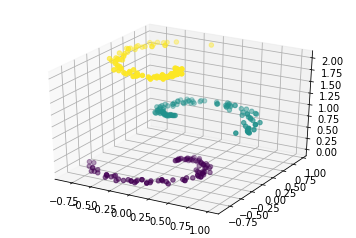

In [12]:
#Plotear datos
bx = plt.axes (projection = '3d')
bx.scatter(datos_t[:,0,0,0], datos_t[:,0,0,1], label_t[:,0], marker='o', c = label_t[:,0])
bx.scatter(datos_v[:,0,0,0], datos_v[:,0,0,1], label_v[:,0], marker='o', c = label_v[:,0])

# 2.- Definir modelo

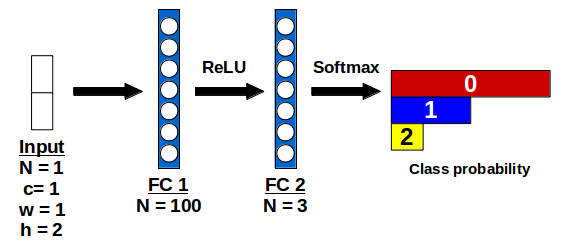

In [13]:
from IPython.display import Image
Image('model/network1.png')

In [14]:
#Imprimir informacion de red
print('Estructura de red neuronal')
!cat model/FCNN_train.prototxt

print('Parametros de optimizacion')
!cat model/solver.prototxt

Estructura de red neuronal
name: "FCNN E1"

##Input Image (Image RGB)
#layer {
#  name:"data"
#  type: "Input"
#  top: "input_data"
#  input_param { shape: { dim: 1 dim: 1 dim: 50 dim: 2 } }
#}

layer {
  name:"Data"
  type: "Data"
  top: "Point"
  top: "Label"
  data_param {
    source: "/home/edgar/Caffe_course/example1/dataset/train_lmdb"
    batch_size: 300
    backend: LMDB
  }
  include: {phase: TRAIN} 
}

layer {
  name:"Data"
  type: "Data"
  top: "Point"
  top: "Label"
  data_param {
    source: "/home/edgar/Caffe_course/example1/dataset/test_lmdb"
    batch_size: 300
    backend: LMDB
  }
  include: {phase: TEST} 
}

##Net Structure

#Layer 1: Fully connected
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "Point"
  top: "fc1"
  inner_product_param {
    num_output: 100
    weight_filler {
      type: "gaussian"
      std: 0.01
    }
    bias_filler {
    	type: "constant"
    	value: 0
    }
  }
}

#Activation layer 1
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "

# 3.- Entrenar Modelo

In [4]:
#Model path
net_root = 'model/'

#Model and solver prototxt
modelo = net_root + 'FCNN_train.prototxt'
solver = net_root + 'solver.prototxt'

##Train for all iterations on solver.prototxt
#Init solver
caffe_solver = caffe.get_solver(solver)

#Train network
#caffe_solver.solve()

##Train for custom iterations
#Number of iterations
it = 150

#Init loss array
train_loss = np.zeros(it)
test_acc = np.zeros(it)

#Train network
#caffe_solver.solve()
for i in range(it):    
    caffe_solver.step(1)
    train_loss[i] = caffe_solver.net.blobs['loss'].data 

[0, 150, 0, 1.2]

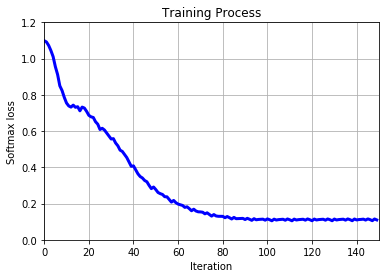

In [5]:
#Imprimir curva de error
plt.plot(np.arange(it), train_loss, linewidth = 3.0, color = 'b')
plt.title('Training Process')
plt.xlabel('Iteration')
plt.ylabel('Softmax loss')
plt.grid(True)
plt.axis([0,150,0,1.2])

# 4.- Probar Modelo 

In [4]:
#Rutas de modelo
model = 'model/FCNN_deploy.prototxt'
weights = 'weights/model_w_iter_100.caffemodel'

#Construir modelo
net = caffe.Net(model, weights, caffe.TEST)
net_init = caffe.Net(model, caffe.TEST)

In [5]:
#Imprimir estructura
for layer_name, blob in net.blobs.iteritems():
    print(layer_name + '\t' + str(blob.data.shape))

Point	(10, 1, 1, 2)
fc1	(10, 100)
relu1	(10, 100)
fc2	(10, 3)
prob	(10, 3)


In [6]:
#Extraer datos
path = "dataset/"
datos_t, label_t = load_lmdb_dataset(path + "train_lmdb", 270, 1, 1, 2)
datos_v, label_v = load_lmdb_dataset(path + "test_lmdb", 30, 1, 1, 2)

print("Entrenamiento: " + str(datos_t.shape) + ", " + str(label_t.shape))
print("Validacion: " + str(datos_v.shape) + ", " + str(label_v.shape))

Entrenamiento: (270, 1, 1, 2), (270, 1)
Validacion: (30, 1, 1, 2), (30, 1)


<IPython.core.display.Javascript object>


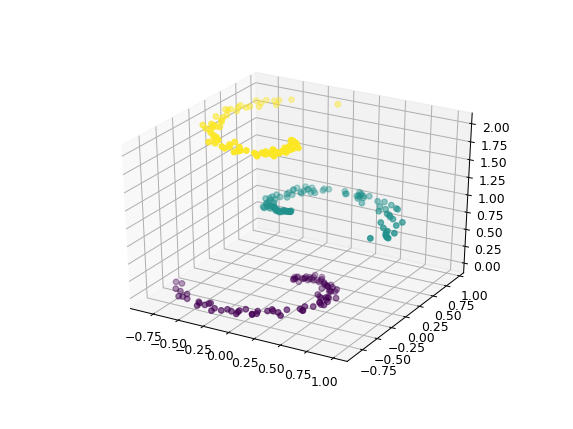

In [9]:
#Ingresar datos de entrenamiento a modelo
y_mod = np.zeros(datos_t.shape[0])
for i in range(datos_t.shape[0]/10):
    net.blobs['Point'].data[...] = datos_t[i*10:10*(i+1), :, :, :]

    #Paso hacia adelante
    out = net.forward()

    #Obtener salida de la red
    p = out['prob']
    y_mod[i*10:10*(i+1)] = np.argmax(p, axis=1)

#Plotear datos
%matplotlib notebook
cx = plt.axes (projection = '3d')
cx.scatter(datos_t[:,0,0,0], datos_t[:,0,0,1], y_mod, marker='o', c = y_mod)

<IPython.core.display.Javascript object>


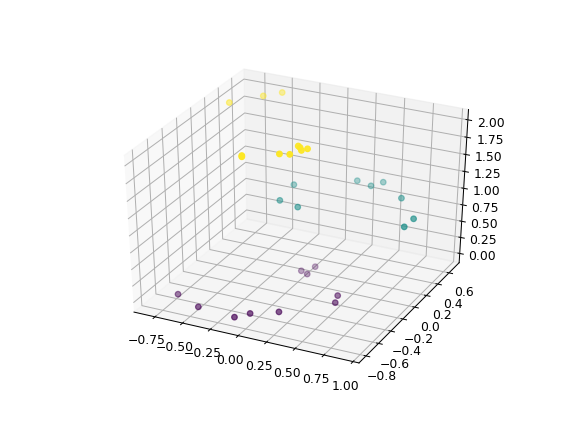

In [11]:
#Ingresar datos de validacion a modelo
y_mod = np.zeros(datos_v.shape[0])
for i in range(datos_v.shape[0]/10):
    net.blobs['Point'].data[...] = datos_v[i*10:10*(i+1), :, :, :]

    #Paso hacia adelante
    out = net.forward()

    #Obtener salida de la red
    p = out['prob']
    y_mod[i*10:10*(i+1)] = np.argmax(p, axis=1)

#Plotear datos
%matplotlib notebook
dx = plt.axes (projection = '3d')
dx.scatter(datos_v[:,0,0,0], datos_v[:,0,0,1], y_mod, marker='o', c = y_mod)